# 2. Probability Distributions


### *Table of Contents*

* 2.1 [Binary Variables](#2.1-Binary-Variables)
    * 2.1.1 [The Beta Distribution](#2.1.1-The-beta-distribution)
* 2.2 [Multinomial Variables](#2.2-Multinomial-Variables)
    * 2.2.1 [The Dirichlet Distribution](#2.2.1-The-Dirichlet-distribution)
* 2.3 [Gaussian Distribution](#2.3-Gaussian-Distribution)
    * 2.3.4 [Maximum likelihood for the Gaussian](#2.3.4-Maximum-likelihood-for-the-Gaussian)
    * 2.3.5 [Sequential estimation](#2.3.5-Sequential-estimation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from prml.distribution import (
    Bernoulli,
    Binomial,
    Beta,
    Categorical,
    Multinomial,
    Dirichlet,
    MultivariateGaussian
)

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## 2.1 Binary Variables

Consider a single binary random variable $x \in \{0, 1\}$, for instance $x$ might be the outcome of flipping a coin. Then, the probability of heads ($x=1$) can be denoted by a parameter $\mu$ so that,

$$
p(x=1|\mu) = \mu
$$

where $0 \leq \mu \leq 1$. The *Bernoulli* probability distribution over $x$ has therefore the form,

$$
\text{Bern}(x|\mu) = \mu^x(1-\mu)^{1-x}
$$

It is easily verified that the Bernoulli distribution has mean given by,

$$
\mathbb{E}[x] = \sum_{x \in \{0, 1\}} x\text{Bern}(x|\mu) =
\sum_{x \in \{0, 1\}} x\mu^x(1-\mu)^{1-x} =
\mu^1(1-\mu)^0 =
\mu
$$

and variance given by,

$$
\begin{align*}
\text{var}[x] &= \mathbb{E}[x]^2 - \mathbb{E}[x^2] \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\text{Bern}(x|\mu) \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\mu^x(1-\mu)^{1-x} \\
&= \mu^2 - \mu = \mu(\mu - 1)
\end{align*}
$$

Now suppose we have given a data set $\mathcal{D} = \{x_1,\dots,x_N\}$ of observed values sampled from an **unknown** Bernoulli distribution (outcomes of coin tosses), that is, the $\mu$ parameter (probability of heads) is unknown.

Fair coin   --  Heads: 51 Tails: 49
Biased coin --  Heads: 16 Tails: 84


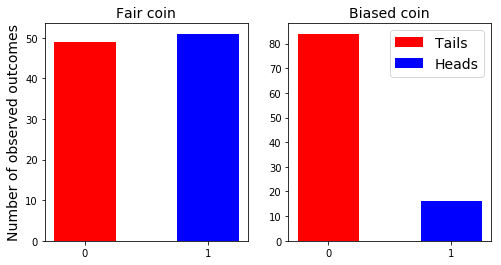

In [2]:
# For demonstration purposes we shall create a data set from a fair coin (mu = 0.5)
# and another data set from a biased coin favoring tails (mu = 0.2).

# Number of coin tosses per data set
N = 100

# Fair coin
mu_fair = 0.5
true_distribution_fair = Bernoulli(mu_fair)
D_fair = true_distribution_fair.draw(N)

print("Fair coin   -- ", "Heads:", sum(D_fair == 1), "Tails:", sum(D_fair == 0))

# Biased coin
mu_biased = 0.2
true_distribution_biased = Bernoulli(mu_biased)
D_biased = true_distribution_biased.draw(N)

print("Biased coin -- ", "Heads:", sum(D_biased == 1), "Tails:", sum(D_biased == 0))

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
b = plt.bar([0,1], [sum(D_fair == 0), sum(D_fair == 1)], color=['red','blue'], width=0.5)
b[0].set_label("Tails")
b[1].set_label("Heads")
plt.ylabel("Number of observed outcomes", fontsize=14)
plt.xticks([0, 1])
plt.title("Fair coin", fontsize=14)

plt.subplot(1,2,2)
b = plt.bar([0,1], [sum(D_biased == 0), sum(D_biased == 1)], color=['red','blue'], width=0.5)
b[0].set_label("Tails")
b[1].set_label("Heads")
plt.xticks([0, 1])
plt.title("Biased coin", fontsize=14)
plt.legend(fontsize=14)

plt.show()

We can use the likelihood function on the assumption that the observations are drawn independently from $\text{Bern}(x|\mu)$, so that,

$$
p(\mathcal{D}|\mu) = \prod_{n=1}^N \text{Bern}(x_n|\mu) = \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n}
$$

Then, following the frequentist approach, we can estimate the value of $\mu$ by maximizing the logarithm of the likelihood given by

$$
\begin{align*}
\ln p(\mathcal{D}|\mu) &= \ln \bigg( \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n} \bigg) \\
&= \sum_{n=1}^N \ln \big( \mu^{x_n}(1-\mu)^{1-x_n} \big) \\
&= \sum_{n=1}^N \bigg( \ln \big( \mu^{x_n} \big) + \ln \big( (1-\mu)^{1-x_n} \big) \bigg) \\
&= \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) 
\end{align*}
$$

Given an observed data set $\mathcal{D}$, we can plot the value of the log-likelihood against the values of $\mu \in [0,1]$.

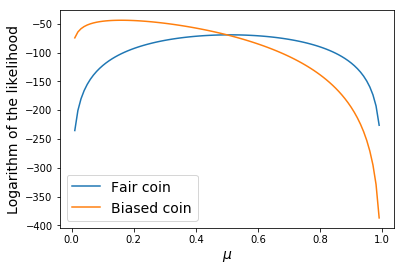

In [3]:
mu_space = np.arange(0.01, 1, 0.01)
ll = np.zeros(mu_space.shape)

for i, mu_i  in enumerate(mu_space):
    ll[i] = Bernoulli(mu_i).log_likelihood_iid(D_fair)

plt.plot(mu_space, ll, label="Fair coin")

for i, mu_i  in enumerate(mu_space):
    ll[i] = Bernoulli(mu_i).log_likelihood_iid(D_biased)

plt.plot(mu_space, ll, label="Biased coin")

plt.xlabel("$\mu$", fontsize=14); plt.ylabel("Logarithm of the likelihood", fontsize=14)
plt.legend(fontsize=14); plt.show()

Note that the **maximum** of the likelihood is achieved around $\mu=0.5$ for the fair coin and $\mu=0.2$ for the biased coin. Therefore, using calculus, if we set the derivative of $\ln p(\mathcal{D}|\mu)$ with respect to $\mu$ equal to zero, we obtain

$$
\begin{align*}
&\frac{\partial}{\partial\mu} \ln p(\mathcal{D}|\mu) = 0 \Leftrightarrow \\
&\frac{\partial}{\partial\mu} \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \frac{\partial}{\partial\mu} \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu}(1-x_n) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu} + \frac{1}{1 - \mu}x_n \bigg) = 0\Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n + \frac{1}{1 - \mu}x_n \bigg) = \frac{N}{1 - \mu} \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1 - \mu}{\mu}x_n + x_n \bigg) = N \Leftrightarrow \\
&\sum_{n=1}^N \frac{1}{\mu}x_n = N \Leftrightarrow \\
&\mu_{ML} = \frac{1}{N}\sum_{n=1}^N x_n
\end{align*}
$$

which is known as the *sample mean*. Thus, the probability of landing heads ($\mu$), according to the maximum likelihood estimator, is given by the fraction of observations of heads in the data set $\mathcal{D}$. Indeed caclulating the sample mean gives us a very accurate estimation of the true values for $\mu$.

In [4]:
print("Maximum likelihood 𝜇 for the fair coin is", sum(D_fair == 1) / N)
print("Maximum likelihood 𝜇 for the biased coin is", sum(D_biased == 1) / N)

Maximum likelihood 𝜇 for the fair coin is 0.51
Maximum likelihood 𝜇 for the biased coin is 0.16


However, A problem that arises from this result is that for small data sets the estimation can be unreasonable. For instance, in the following plot, note that for small data sets $N < 100$, the estimated $\mu_{\text{ML}}$ can deviate significantly from the true $\mu$ leading to incorrect probabilities for the future observations.

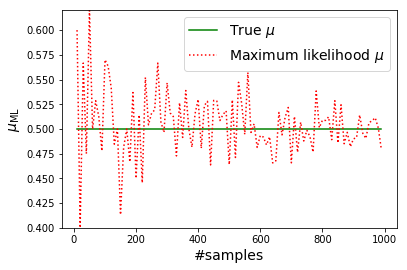

In [5]:
ml_model = Bernoulli()
samples = list(range(10, 1000, 10))
mu_estimations = []

for N in samples:
    D = true_distribution_fair.draw(N)
    ml_model.ml(D)
    mu_estimations.append(ml_model.mu)
    
plt.plot(samples, [mu_fair for N in samples], color="g", label="True $\mu$")
plt.plot(samples, mu_estimations, color="r", linestyle=":", label="Maximum likelihood $\mu$")
plt.xlabel("#samples", fontsize=14); plt.ylabel("$\mu_{\mathrm{ML}}$", fontsize=14)
plt.ylim([min(mu_estimations), max(mu_estimations)])
plt.legend(fontsize=14); plt.show()

Now, if we toss a coin $5$ times, then, the probability of getting $3$ heads and then $2$ tails is

$$
p(x_1=1)p(x_2=1)p(x_3=1)p(x_4=0)p(x_5=0) = \mu \times \mu \times \mu \times (1 - \mu) \times (1 - \mu)
$$

or more general for $N$ times and $m$ heads, 

$$
\mu^m(1-\mu)^{N-m}
$$

However, this is just one way to get $m$ heads, there are many other sequences of $N$ trials that would give us $m$ heads. How many exactly?

The distribution describing the number of $m$ observations of $x=1$ in a sample dataset of size $N$ is called the [*Binomial* distribution](https://www.youtube.com/watch?v=8idr1WZ1A7Q), and is given by

$$
\text{Bin}(m|N,\mu) = 
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
\mu^m(1 - \mu)^{N-m}
$$

where

$$
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
= \frac{N!}{(N-m)!m!}
$$

is the numbers of ways of choosing $m$ objects out of a total of $N$ identical objects, and is called the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient).

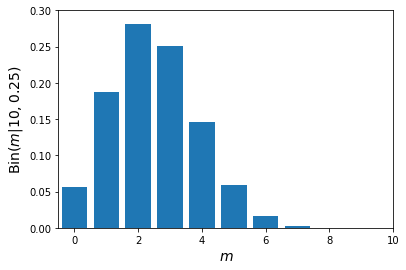

In [6]:
model = Binomial(10, 0.25)
y = model.pdf(np.arange(0, 10))

plt.bar(np.arange(0, 10), y)
plt.xlim([-0.5, 10]); plt.ylim([0, 0.3])
plt.xlabel("$m$", fontsize=14); plt.ylabel("$\mathrm{Bin}(m|10,0.25)$", fontsize=14)
plt.show()

### 2.1.1 The beta distribution

We have seen that the maximum likelihood estimator for the parameter $\mu$ in the Bernoulli and binomial distributions, is given by the fraction of the observations in the data having $x=1$, which can lead to over-fitted results for small data sets. In order to arrive to more sensible results, we develop a **Bayesian treatment** for the problem by introducing a prior distribution $p(\mu)$ over the parameter $\mu$.

Note that the likelihood function takes the form of the product of factors of the form $\mu^x(1-\mu)^{(1-x)}$. We would like to choose a prior proportional to powers of $\mu$ and $(1-\mu)$ in order for the posterior to have the same functional form as the prior, since the posterior is proportional to the product of the prior and the likelihood. This important property is called **conjugacy**.

We therefore we choose a prior, called the **beta** distribution, given by

$$
\text{Beta}(\mu|a,b) = \frac{\Gamma(a + b)}{\Gamma(a)\Gamma(b)} \mu^{a-1}(1-\mu)^{b-1}
$$

where $a$ and $b$ are often called hyperparameters because they control the distribution of the parameter $\mu$. In order to give an intuition about the hyperparameteres, we plot the beta distribution for various values of $a$ and $b$.

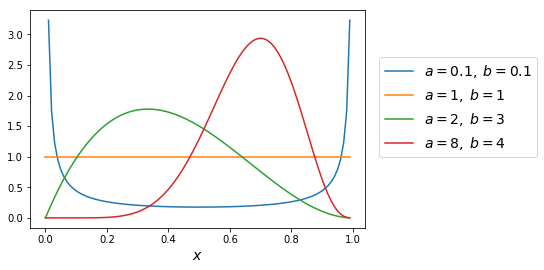

In [7]:
x_space = np.arange(0, 1, 0.01)

for a, b in [(0.1, 0.1), (1, 1), (2, 3), (8, 4)]:
    model = Beta(a, b)
    plt.plot(x_space, model.pdf(x_space), label="$a={},\; b={}$".format(a, b))

plt.xlabel("$x$", fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.85), loc=2, borderaxespad=1, fontsize=14); plt.show()

The fraction of $\Gamma(x)$ functions ensures that the beta distribution is normalized, so that

$$
\int_0^1 \text{Beta}(\mu|a,b)d\mu = 1
$$

The mean is given by

$$
\begin{align*}
\mathbb{E}[\mu] &= \int_0^1 \mu\text{Beta}(\mu|a,b)d\mu \\
&= \int_0^1 \mu\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^{a-1}(1-\mu)^{b-1} d\mu \\
&= \int_0^1 \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \int_0^1 \frac{a\Gamma(a+b+1)}{(a+b)\Gamma(a+1)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \frac{a}{a+b}\int_0^1 \frac{\Gamma(a+b+1)}{\Gamma(a+1)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \frac{a}{a+b}\int_0^1 \text{Beta}(\mu|a+1,b)d\mu \\
&= \frac{a}{a+b}
\end{align*}
$$

where we have taken advantage of the property $\Gamma(x+1)=x\Gamma(x)$. The variance is given by

$$
\text{var}[\mu] = \frac{ab}{(a+b)^2(a+b+1)}
$$

The posterior distribution over $\mu$ can be obtained by multiplying the beta prior by the binomial likelihood function,

$$
p(\mu|m,l,a,b) = \text{Bin}(m|N,\mu)\text{Beta}(\mu|a,b) = 
\frac{\Gamma(m+a+l+b)}{\Gamma(m+a)\Gamma(l+b)} \mu^{m+a-1}(1-\mu)^{l+b-1}
$$

where $l=N-m$, and corresponds to the number of times $x=0$.

Note that the effect of observing a data set of $m$ observations of $x=1$ and $l$ observations of $x=0$ is to  increase the value of $a$ by $m$, and the value of $b$ by $l$, from the prior to the posterior distribution. Thus, the hyperparameters $a$ and $b$ in the prior represent the number of observations of $x=1$ and $x=0$, respectively. Furthermore, the posterior distribution can act as the prior if subsequent observations arrive. Imagine taking one observation at a time and after each observation updating the current posterior distribution by multiplying by the likelihood of the incoming observation. At each stage, the posterior is a beta distribution incorporating some number of (prior and actual) observed values for $x=1$ and $x=0$ given by the parameters $a$ and $b$. Incorporation an additional observation of $x=1$ corresponds to incrementing the value of $a$ by $1$, whereas for $x=0$ increment $b$ by $1$.

We present a sequence of such Bayesian inference steps, where three observations of $x=1$ arrive before a single observation of $x=0$. Note how the prior revises the form of the posterior on each update step according to the likelihood. Apart from the first step, where the prior is a Beta distribution having paramater $a=2$ and $b=2$, in each subsequent step the prior is the posterior of the previous step.

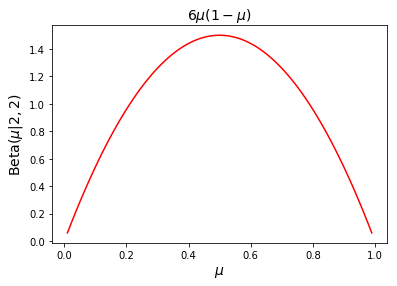

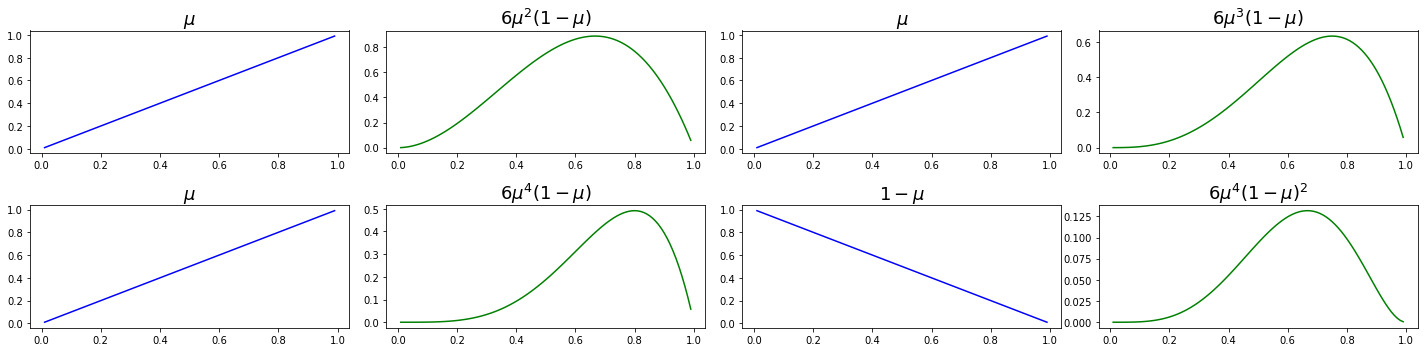

In [8]:
# The Beta conjugate prior for the Binomial distribution (starting parameter a=2, b=2)
prior = Beta(a=2, b=2)
plt.plot(mu_space, prior.pdf(mu_space), color='red')
plt.xlabel('$\mu$', fontsize=14); plt.ylabel('$\mathrm{Beta}(\mu|2,2)$', fontsize=14)
plt.title(prior.change_notation({'x': 'mu'}).to_latex, fontsize=14)
plt.show()

# Apply a sequence of Bayesian inference steps, as more observations arrive in the form of a likelihood
plt.figure(figsize=(20, 5))

# Row 1
plt.subplot(2,4,1)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,2)
plt.tight_layout()
posterior = prior.change_notation({'x': 'mu'}) * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.subplot(2,4,3)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,4)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

# Row 2
plt.subplot(2,4,5)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,6)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.subplot(2,4,7)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(0)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,8)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.show()

Thus, the **sequential** approach to learning arises naturally when we adopt a Bayesian viewpoint. It is **independent** of the choice of prior and of the likelihood function and **depends only** on the assumption of i.i.d. data. Sequential methods make use of observations one at a time, or in small batches, and then discard them before the next observations are used. They can be used, for example, in real-time learning scenarios where a steady stream of data is arriving, and predictions must be made before all of the data is seen. Maximum likelihood methods can also be cast into a sequential framework.

If our goal is to predict the outcome fo the next trial, then we must evaluate the predictive distribution of $x$ given the observed data $\mathcal{D}$ given by,

$$
p(x=1|\mathcal{D}) = \frac{m + a}{m + a + l + b}
$$

which essentially represents the fraction of observations (actual and prior) that corresponds to $x=1$. Note that in the limit of an infinitely large data set $m,l \to \infty$, $p(x=1|\mathcal{D})$ reduces to the maximum likelihood estimator $\frac{m}{N}$. 

It is a very **general property** that the Bayesian and maximum likelihood results are identical in the limit of infinitely large data sets. For finite data set, the posterior mean for $\mu$ always lies between the prior mean and the maximum likelihood estimate for $\mu$, corresponding to the sample mean.

## 2.2 Multinomial Variables

A binary variable is good for representing a coin toss, but generally we would like to have more states, such as the number rolled on a die. Such discrete random variables can take on one of $K$ possible mutually exclusive states of the form

$$
\mathbf{x} = (0,0,1,0,0,0)^{\text{T}}
$$

where each state $k$ is represented by the $k^{th}$ element being $1$ and all other elements being $0$. If we denote the probability of $x_k=1$ by the parameter $\mu_k$, then the distribution over $\mathbf{x}$ can be regarded as a generalization of the Bernoulli distribution, called the *categorical distribution*, and is given by

$$
p(\mathbf{x}|\boldsymbol\mu) = \prod_{k=1}^K \mu_k^{x_k}
$$

where the parameters $\mathbf{x} = (\mu_1,\dots\mu_K)^{\text{T}}$ must satisfy $\mu_k \geq 0$ and $\sum_k \mu_k = 1$ because they represent probabilities. Note that $\mu_k^{x_k}$ becomes $1$ for every element except the $x_k=1$, and so the product picks the probability $\mu_k$ for the state represented by $\mathbf{x}$.


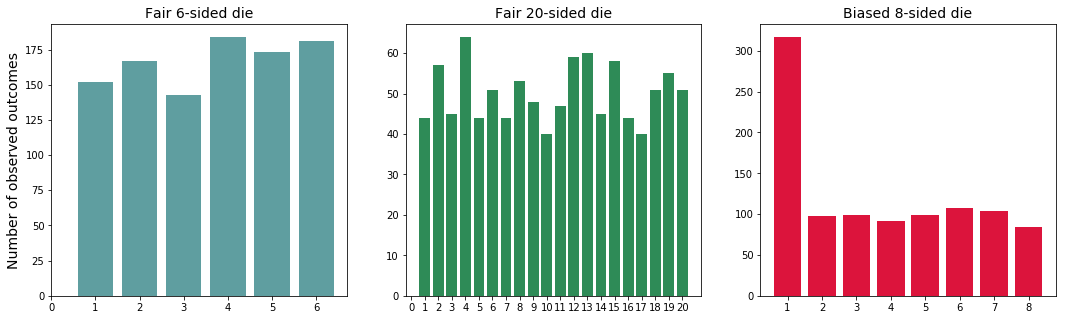

In [9]:
plt.figure(figsize=(18, 5))

# Lets roll 1000 fair 6-sided dice
plt.subplot(1,3,1)
fair_rolls_6 = Categorical(mu=np.ones(6) / 6).draw(1000)
plt.bar(np.arange(1,7), sum(fair_rolls_6), color="cadetblue")
plt.ylabel("Number of observed outcomes", fontsize=14)
plt.xticks(np.arange(6+1))
plt.title("Fair 6-sided die", fontsize=14)

# then 1000 fair 20-sided dice
plt.subplot(1,3,2)
fair_rolls_20 = Categorical(mu=np.ones(20) / 20).draw(1000)
plt.bar(np.arange(1,21), sum(fair_rolls_20), color="seagreen")
plt.xticks(np.arange(20+1))
plt.title("Fair 20-sided die", fontsize=14)

# finally 1000 biased 8-sided dice
plt.subplot(1,3,3)
biased_rolls_8 = Categorical(mu=np.array([3, 1, 1, 1, 1, 1, 1, 1], float) / 10).draw(1000)
plt.bar(np.arange(1,9), sum(biased_rolls_8), color="crimson")
plt.title("Biased 8-sided die", fontsize=14)

plt.show()

It is easily seen that the distribution is normalized

$$
\begin{align*}
\sum_{\mathbf{x}} p(\mathbf{x}|\boldsymbol\mu) &= \sum_{\mathbf{x}}\prod_{k=1}^K \mu_k^{x_k} \\
&= \prod_{k=1}^K \mu_k^{x_k^1} + \dots + \prod_{k=1}^K \mu_k^{x_k^K} \\
&= \sum_{k=1}^K \mu_k = 1
\end{align*}
$$

and that

$$
\begin{align*}
\mathbb{E}[\mathbf{x}] &= \mathbb{E}[\mathbf{x}|\boldsymbol\mu] \\
&= \sum_\mathbf{x} \mathbf{x} p(\mathbf{x}|\boldsymbol\mu) \\
&= \sum_\mathbf{x} \mathbf{x} \prod_{k=1}^K \mu_k^{x_k} \\
&= \mathbf{x}^1 \prod_{k=1}^K \mu_k^{x_k^1} + \dots + \mathbf{x}^K \prod_{k=1}^K \mu_k^{x_k^K} \\
&= (\mu_1,\dots,\mu_K)^\text{T}
\end{align*}
$$

Consider a data set $\mathcal{D}$ of $N$ independent observations $\mathbf{x}_1,\dots,\mathbf{x}_N$, the corresponding likelihood function is given by

$$
\begin{align*}
p(\mathcal{D}|\boldsymbol\mu) &= \prod_{n=1}^N \prod_{k=1}^K \mu_k^{x_{nk}} \\
&= \prod_{k=1}^K \mu_k^{\Large(\sum_{n=1}^N x_{nk}\Large)} \\
&= \prod_{k=1}^K \mu_k^{m_k}
\end{align*}
$$

Therefore, given some observed dice rolls, we can plot, for instance, how likely it is that the number one in the die that produced these observations is biased in a certain way

[0.28571429 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]
[0.5 0.1 0.1 0.1 0.1 0.1]


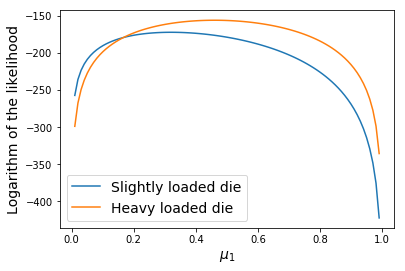

In [10]:
N = 100

def likelihood(mu_1, data):
    mus = (np.ones(6) * (1 - mu_1)) / 5
    mus[0] = mu_1
    return Categorical(mu=mus).log_likelihood_iid(data)

mu_space = np.linspace(0, 1, 100)

nums = np.array([2,1,1,1,1,1], float)
print(nums / sum(nums))
slightly_loaded_data = Categorical(mu=nums / sum(nums)).draw(N)
plt.plot(mu_space, [likelihood(mu_1, slightly_loaded_data) for mu_1 in mu_space], label="Slightly loaded die")

nums = np.array([5,1,1,1,1,1], float)
print(nums / sum(nums))
heavy_loaded_data = Categorical(mu=nums / sum(nums)).draw(N)
plt.plot(mu_space, [likelihood(mu_1, heavy_loaded_data) for mu_1 in mu_space], label="Heavy loaded die")

plt.xlabel("$\mu_1$", fontsize=14); plt.ylabel("Logarithm of the likelihood", fontsize=14)
plt.legend(fontsize=14); plt.show()

In order to maximize $\ln p(\mathcal{D}|\boldsymbol\mu)$, taking account of the constraint $c(\boldsymbol\mu)=\sum_k \mu_k - 1$, we use a Lagrange multiplier $\lambda$ and maximizing

$$
L(\boldsymbol\mu,\lambda) = \ln p(\mathcal{D}|\boldsymbol\mu) + \lambda c(\boldsymbol\mu)
$$

By setting the gradient to zero, we obtain the maximum likelihood solution in the form

$$
\mu_k = \frac{m_k}{N}
$$

which is the fraction of the $N$ observations for which $x_k=1$. Thus, the maximum likelihood solution, similar to the Bernoulli distribution, is the *sample mean* on each dimension.

In [11]:
print("Maximum likelihood of 𝝁 for the slightly loaded die is", np.mean(slightly_loaded_data, axis=0))
print("Maximum likelihood of 𝝁 for the heavy loaded die is", np.mean(heavy_loaded_data, axis=0))

Maximum likelihood of 𝝁 for the slightly loaded die is [0.32 0.13 0.14 0.12 0.13 0.16]
Maximum likelihood of 𝝁 for the heavy loaded die is [0.46 0.11 0.11 0.12 0.09 0.11]


The joint distribution of the quantities $m_1,\dots,m_K$, conditioned on the parameters $\boldsymbol\mu$ and the total number $N$ of observations, is known as the *multinomial* distribution. It would give us the number of $1, 2, 3, \dots$ rolled in a sample dataset of size $N$, the same way the binomial distribution gave us the number of heads. The multinomial distribution is given by
 
$$
\text{Mult}(m_1,\dots,m_K|\boldsymbol\mu,N) = 
\left(\!
    \begin{array}{c}
      N \\
      m_1m_2\dots m_K
    \end{array}
\!\right)
\prod_{k=1}^K \mu_k^{m_k}
$$

where

$$
\left(\!
    \begin{array}{c}
      N \\
      m_1m_2\dots m_K
    \end{array}
\!\right) =
\frac{N!}{m_1!m_2!\dots m_K!}
$$

 is the number of ways to partition $N$ objects into $K$ groups of size $m_1,\dots,m_K$, and is called the [multinomial coefficient](https://en.wikipedia.org/wiki/Multinomial_theorem).
 
We cannot really plot the multinomial distribution directly, because of the many dimensions of $\mathbf{m}$. However, we can show the distribution of the number of ones rolled (constraining the other numbers), using various weighted dice.

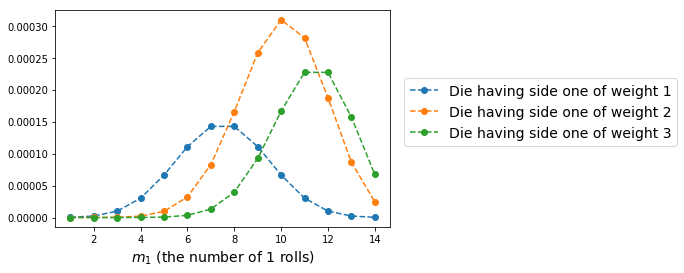

In [12]:
# Consider N tosses of a 6-sided die. 
N = 35
m_space = np.arange(1, 15)

# The weight parameter determines how biased is side 1 of the die
for w in [1, 2, 3]:
    nums = np.array([w, 1, 1, 1, 1, 1])
    distribution = Multinomial(N, mu=nums / sum(nums))
    plt.plot(m_space, [distribution.pdf(np.array([m1, 5, 5, 5, 5, 15 - m1]).T) for m1 in m_space], 
             'o--', label='Die having side one of weight %s' % w)

plt.xlabel("$m_1$ (the number of $1$ rolls)" , fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.75), loc=2, borderaxespad=1, fontsize=14); plt.show()

And we can plot the distribution over a $3$ sided die in using a colormap. Note that the plot only depicts two  variables on the axes, since the third can be inferred as they sum to N.

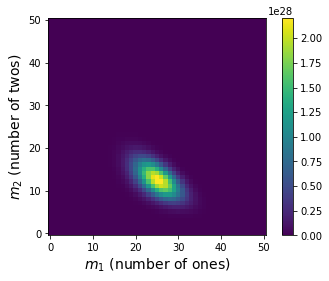

In [13]:
N = 50
m_space = np.arange(N + 1)
distribution = Multinomial(N, mu=np.array([2, 1, 1]).T)

o = np.ones((N + 1, N + 1))
for m1 in m_space:
    for m2 in np.arange((N - m1) + 1):
        m3 = N - m1 - m2
        o[m2, m1] = distribution.pdf(np.array([m1, m2, m3]).T)

plt.imshow(o, origin="lower")
plt.xlabel("$m_1$ (number of ones)", fontsize=14); plt.ylabel("$m_2$ (number of twos)", fontsize=14)
plt.colorbar(); plt.show()

### 2.2.1 The Dirichlet distribution

Similar to the Beta distribution, consider a family of prior distributions for the parameters $\boldsymbol\mu$ of the multinomial distribution, called the *Dirichlet* distribution

$$
\text{Dir}(\boldsymbol\mu|\boldsymbol\alpha) = 
\frac{\Gamma(\alpha_0)}{\Gamma(\alpha_1)\cdots\Gamma(\alpha_K)} \prod_{k=1}^K \mu_k^{\alpha_k-1}
$$

In order to give an intuition we plot the Dirichlet distribution over three variables. Two of them are shown in horizontal axes are coordinates in the plane of the simplex, while the vertical axis corresponds to the value of the density.

In [ ]:
fig = plt.figure(figsize=(20, 5))

for i, alpha in enumerate([0.1, 1, 10]):
    
    distribution = Dirichlet(np.array([alpha, alpha, alpha]))
    X1, X2 = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
    X3 = 1 - (X1 + X2)

    X = np.array([np.ravel(X1), np.ravel(X2), [float('nan') if x < 0 else x for x in np.ravel(X3)]]).T    
    Z = distribution.pdf(X).reshape(X1.shape)

    ax = fig.add_subplot(1, 3, i + 1, projection='3d'); ax.grid(b=None)
    ax.plot_surface(X1, X2, Z)
    ax.set_xlabel("$\mu_1$", fontsize=14); ax.set_ylabel("$\mu_2$", fontsize=14)
    ax.set_title("$\\alpha_k={}$".format(str(alpha)), fontsize=18)

plt.show()

Multiplying the Dirichlet prior by the multinomial likelihood function, we obtain the posterior distribution for the parameters $\boldsymbol\mu$ in the form

$$
p(\boldsymbol\mu|\mathcal{D},\boldsymbol\alpha) = 
\text{Dir}(\boldsymbol\mu|\boldsymbol\alpha + \mathbf{m}) =
\frac{\Gamma(\alpha_0 + N)}{\Gamma(\alpha_1 + m_1)\cdots\Gamma(\alpha_K + m_K)} \prod_{k=1}^K \mu_k^{\alpha_k+m_k-1}
$$

Note that the posterior distribution again takes the form of a Dirichlet distribution, confirming that the Dirichlet is indeed a **conjugate prior** for the multinomial distribution. As in the case of the binomial distribution and the beta prior, the parameters $\alpha_k$ of the Dirichlet prior can be interpreted as an *effective number of observations* of $x_k = 1$. Thus, the effect of observing a data set of $\mathbf{m}$ observations for the $K$ states of $\mathbf{x}$ is to increase the values of $\boldsymbol\alpha$ by $\mathbf{m}$ from the prior to the posterior distribution. 

To that end, we present a Bayesian inference step, where an observations of $\mathbf{x}=(1, 0, 0)^\text{T}$ arrives. Given a Dirichlet prior having parameters $\boldsymbol\alpha=(2, 2, 2)^\text{T}$, note how the prior revises the form of the posterior according to the likelihood.

In [ ]:
# Apply a sequence of Bayesian inference steps, as more observations arrive in the form of a likelihood
fig = plt.figure(figsize=(20, 5))

# The Dirichlet conjugate prior for the multinomial distribution (starting parameters a=[2, 2, 2])
prior = Dirichlet(alpha=np.array([2, 2, 2]).T)
Z = prior.pdf(X).reshape(X1.shape)
ax = fig.add_subplot(1, 3, 1, projection='3d'); ax.grid(b=None)
ax.plot_surface(X1, X2, Z)
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("$\mu_2$", fontsize=14)
ax.set_title(prior.change_notation({'x': 'mu'}).to_latex, fontsize=18)

# The multinomial likelihood
ax = fig.add_subplot(1, 3, 2, projection='3d'); ax.grid(b=None)
likelihood = Multinomial(n=1, dim=3).pdf(np.array([1, 0, 0]).T)
Z = likelihood.pdf(mu=X).reshape(X1.shape)
ax.plot_surface(X1, X2, Z)
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("$\mu_2$", fontsize=14)
ax.set_title(likelihood.to_latex, fontsize=18)

# The resulting posterior
ax = fig.add_subplot(1, 3, 3, projection='3d'); ax.grid(b=None)
posterior = prior.change_notation({'x': 'mu'}) * likelihood
Z = posterior.pdf(mu=X).reshape(X1.shape)
ax.plot_surface(X1, X2, Z)
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("$\mu_2$", fontsize=14)
ax.set_title(posterior.to_latex, fontsize=18)

plt.show()

## 2.3 Gaussian Distribution

The *Gaussian*, also known as the normal distribution, is a model for the distribution of continuous random variables. In the case of single variable $x$, the Gaussian distribution is given by

$$
\mathcal{N}(x|\mu,\sigma^2) =
\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\Big\{-\frac{1}{2\sigma^2}(x-\mu)^2\Big\}
$$

For a $D$-dimensional vector $\mathbf{x}$, the multivariate Gaussian distribution takes the form

$$
\mathcal{N}(\mathbf{x}|\boldsymbol\mu,\mathbf{\Sigma}) =
\frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}}
\exp\Big\{-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol\mu)\Big\}
$$

where $\boldsymbol\mu$ is a $D$-dimensional mean vector, $\mathbf{\Sigma}$ is a $D\times D$ covariance matrix, while $|\mathbf{\Sigma}|$ denotes the determinant of $\mathbf{\Sigma}$.

The Gaussian distribution can be motivated from a variety of perspectives. For instance, we have seen that for continuous variables, the distribution **maximizing the entropy** is a Gaussian distribution. Moreover, the *central limit theorem* tell us that the sum of a set of random variables, which is of course itself a random variable, has a distribution that becomes increasingly Gaussian as the number of terms increases.

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sample = np.mean(np.random.uniform(0, 1, size=(1, 100000)), axis=0)
plt.hist(sample, bins=20, density=True, color="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.xlim(0, 1); plt.ylim(0, 5)
plt.title("$N=1$", fontsize=14)

plt.subplot(1, 3, 2)
sample = np.mean(np.random.uniform(0, 1, size=(2, 100000)), axis=0)
plt.hist(sample, bins=20, density=True, color="steelblue")
plt.xlabel("$x_1+x_2$", fontsize=14); plt.xlim(0, 1); plt.ylim(0, 5)
plt.title("$N=2$", fontsize=14)

plt.subplot(1, 3, 3)
sample = np.mean(np.random.uniform(0, 1, size=(10, 100000)), axis=0)
plt.hist(sample, bins=20, density=True, color="steelblue")
plt.xlabel("$x_1+x_2+\cdots+x_{10}$", fontsize=14); plt.xlim(0, 1); plt.ylim(0, 5)
plt.title("$N=10$", fontsize=14)

plt.show()


Although the Gaussian distribution is widely used as a density model, it suffers from significant limitations: 

1. Consider the number of free parameters in the distribution. A general symmetric covariance matrix $\mathbf{\Sigma}$ has $D(D+1)/2$ independent parameters, and there are another $D$ independent parameters in $\boldsymbol\mu$, resulting in $D(D+3)/2$ parameters in total. Since the total number of parameters grows quadratically with $D$, manipulation and inversion of large matrices becomes prohibitive.


2. One way of addressing these problems is by considering restricted forms of the covariance matrix, such as *diagonal*, $\mathbf{\Sigma}=diag(\sigma_i^2)$, or even *isotropic*, $\mathbf{\Sigma}=\sigma_i^2\mathbf{I}$, covariance matrices. Unfortunately, whereas such approaches limit the number of degrees of freedom in the distribution, making the inversion of the covariance matrix faster, they also greatly restrict the form of the probability density and its ability to capture interesting correlations in the data.


3. The Gaussian distribution is intrinsically unimodal (i.e., has a single maximum), and so is unable to  approximate multimodal distributions.

In [ ]:
# Generate 100 points in the interval [-5, 5]
N = 100
X1, X2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
X = np.array([np.ravel(X1), np.ravel(X2)])

plt.figure(figsize=(18, 5))

# General covariance matrix
generic_sigma = np.array(
    [[1.5, 0.92],
     [0.92, 2.2]]
)
N_distribution = MultivariateGaussian(np.zeros((2, 1)), generic_sigma)
p = np.diag(N_distribution.pdf(X)).reshape(X1.shape)

plt.subplot(1, 3, 1)
plt.contourf(X1, X2, p, cmap='binary')
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])

# Diagonal covariance matrix
diagonal_sigma = np.array(
    [[1.5, 0],
     [0, 2.2]]
)
N_distribution = MultivariateGaussian(np.zeros((2, 1)), diagonal_sigma)
p = np.diag(N_distribution.pdf(X)).reshape(X1.shape)

plt.subplot(1, 3, 2)
plt.contourf(X1, X2, p, cmap='binary')
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])

# Isotropic covariance matrix
isotropic_sigma = np.array(
    [[1.0, 0],
     [0, 1.0]]
)
N_distribution = MultivariateGaussian(np.zeros((2, 1)), isotropic_sigma)
p = np.diag(N_distribution.pdf(X)).reshape(X1.shape)

plt.subplot(1, 3, 3)
plt.contourf(X1, X2, p, cmap='binary')
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])

plt.show()

### 2.3.4 Maximum likelihood for the Gaussian

Given a data set $\mathbf{X}=(\mathbf{x}_1,\dots,\mathbf{x}_N)^\text{T}$, in which the observations $\mathbf{x}_n$ are assumed to be drawn indepdendently from a multivariate Gaussian distribution, we can estimate the parameters of the distribution by maximum likelihood. The logarithm of the likelihood function is given by

$$
\begin{align*}
\ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma}) &= 
\ln \bigg( \prod_{n=1}^N \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu,\mathbf{\Sigma}) \bigg) \\
&= \ln \bigg( \prod_{n=1}^N \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \exp\Big\{-\frac{1}{2}(\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu)\Big\} \bigg) \\
=& \sum_{n=1}^N \ln \bigg( \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \exp\Big\{-\frac{1}{2}(\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu)\Big\} \bigg) \\
=& \sum_{n=1}^N \ln \bigg( \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \bigg) + \sum_{n=1}^N \ln \exp\Big\{-\frac{1}{2}(\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu)\Big\} \\
=& N \ln \bigg( \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \bigg) -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \\
=& - N \ln \big( (2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2} \big) -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \\
=& - \frac{ND}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \\
\end{align*}
$$

Taking the derivative of the log-likelihood over $\boldsymbol\mu$ and set it equal to $0$, we obtain the solution for the maximum likelihood estimate of the mean, given by

$$
\begin{align*}
\frac{\partial}{\partial\boldsymbol\mu} \ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma}) = 0 &\Leftrightarrow
\frac{\partial}{\partial\boldsymbol\mu} \bigg( - \frac{ND}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
&\Leftrightarrow \frac{\partial}{\partial\boldsymbol\mu} \bigg( -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
&\Leftrightarrow -\frac{1}{2} \sum_{n=1}^N \mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) = 0 \\
&\Leftrightarrow \sum_{n=1}^N \mathbf{x}_n - N\boldsymbol\mu = 0 \\
&\Leftrightarrow \boldsymbol\mu_{ML} = \frac{1}{N} \sum_{n=1}^N \mathbf{x}_n
\end{align*}
$$

which is often called the *sample mean vector*. Calculating the derivative of the log-likelihood over $\mathbf{\Sigma}$ and set it equal to $0$ is given by

$$
\begin{align*}
\frac{\partial}{\partial\mathbf{\Sigma}} \ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma}) = 0 &\Leftrightarrow
\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( - \frac{ND}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
&\Leftrightarrow \frac{\partial}{\partial\mathbf{\Sigma}} \bigg(- \frac{N}{2} \ln|\mathbf{\Sigma}| \bigg)-\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( \frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
\end{align*}
$$

By using (C.28) the first term can be reduced to

$$
\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( -\frac{N}{2} \ln|\mathbf{\Sigma}| \bigg) =
-\frac{N}{2} (\mathbf{\Sigma}^{-1})^\text{T} =
-\frac{N}{2} \mathbf{\Sigma}^{-1}
$$

where the last equality holds because $\mathbf{\Sigma}$ is symmetric. For the second term, we can derive that,

$$
\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( \frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 
\frac{N}{2}\mathbf{\Sigma}^{-1}\mathbf{S}\mathbf{\Sigma}^{-1}
$$

where 

$$
\mathbf{S}=\frac{1}{N}=\sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)(\mathbf{x}_n-\boldsymbol\mu)^\text{T}
$$

Thus, we obtain

$$
\begin{align*}
-\frac{N}{2} \mathbf{\Sigma}^{-1} + \frac{N}{2}\mathbf{\Sigma}^{-1}\mathbf{S}\mathbf{\Sigma}^{-1} &= 0
\Leftrightarrow\\
\frac{N}{2}\mathbf{\Sigma}^{-1}\mathbf{S}\mathbf{\Sigma}^{-1} &= \frac{N}{2} \mathbf{\Sigma}^{-1}
\Leftrightarrow\\
\mathbf{\Sigma} &= \mathbf{S}
\Leftrightarrow\\
\mathbf{\Sigma}_{ML} &= \frac{1}{N}=\sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu_{ML})(\mathbf{x}_n-\boldsymbol\mu_{ML})^\text{T}
\end{align*}
$$

However, if we evaluate the expectations of the maximum likelihood solutions under the true distribution, we obtain the following results

$$
\mathbb{E}[\boldsymbol\mu_{ML}] = \frac{1}{N}\mathbb{E}\bigg[ \sum_{n=1}^N \mathbf{x}_n \bigg] =
\frac{1}{N}\sum_{n=1}^N\mathbb{E}[\mathbf{x}_n] = \frac{1}{N} N\boldsymbol\mu = \boldsymbol\mu
$$

and

$$
\mathbb{E}[\mathbf{\Sigma}_{ML}] = \frac{N-1}{N}\mathbf{\Sigma}
$$

Thus, similar to the univariate Gaussian distribution, the expectation of the maximum likelihood estimate for the mean is equal to the true mean, while for the covariance has an expectation that is less than the true value, and hence it is biased. We can correct the bias by defining a different estimator given by

$$
\tilde{\mathbf{\Sigma}} = \frac{1}{N-1} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu_{ML})(\mathbf{x}_n-\boldsymbol\mu_{ML})^\text{T}
$$

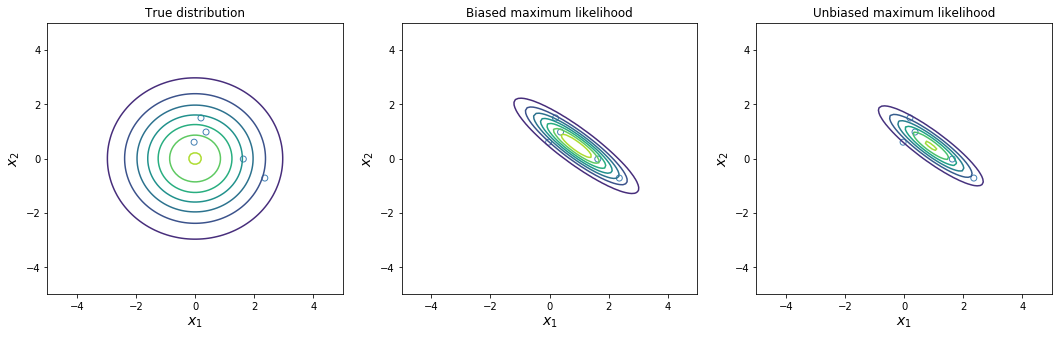

In [20]:
X = np.random.multivariate_normal(mean=np.array([0, 0]), cov=1.5 ** 2 * np.eye(2), size=5)

x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

plt.figure(figsize=(18, 5))

gaussian = MultivariateGaussian(mu=np.zeros((2, 1)), cov=1.5 ** 2 * np.eye(2))
p = np.diag(gaussian.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.subplot(1, 3, 1)
plt.contour(x, y, p)
plt.scatter(X[:, 0], X[:, 1], facecolor="none", edgecolor="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.ylabel("$x_2$", fontsize=14)
plt.title('True distribution')

gaussian = MultivariateGaussian(dim=2)
gaussian.ml(X, unbiased=False)
p = np.diag(gaussian.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.subplot(1, 3, 2)
plt.contour(x, y, p)
plt.scatter(X[:, 0], X[:, 1], facecolor="none", edgecolor="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.ylabel("$x_2$", fontsize=14)
plt.title('Biased maximum likelihood')

gaussian1 = MultivariateGaussian(dim=2)
gaussian1.ml(X, unbiased=True)
p1 = np.diag(gaussian1.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.subplot(1, 3, 3)
plt.contour(x, y, p1)
plt.scatter(X[:, 0], X[:, 1], facecolor="none", edgecolor="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.ylabel("$x_2$", fontsize=14)
plt.title('Unbiased maximum likelihood')

plt.show()

### 2.3.5 Sequential estimation

Sequential or online methods allow data points to be processed one at a time and then discarded. They are important when large data sets are involved so that batch processing of all data at once is infeasible. Consider for instance, the maximum likelihood solution for the multivariate Gaussian distribution. Lets denote  the solution based on $N$ observations as $\boldsymbol\mu_{ML}^{(N)}$. The, by dissecting the contribution from the final data point $\mathbf{x}_N$ we obtain

$$
\begin{align*}
\boldsymbol\mu_{ML}^{(N)} &= \frac{1}{N}\sum_{n=1}^N \mathbf{x}_n \\
&= \frac{1}{N}\mathbf{x}_Ν + \frac{1}{N}\sum_{n=1}^{N-1} \mathbf{x}_n \\
&= \frac{1}{N}\mathbf{x}_Ν + \frac{N-1}{N}\boldsymbol\mu_{ML}^{(N-1)} \\
&= \boldsymbol\mu_{ML}^{(N-1)} + \frac{1}{N}\big(\mathbf{x}_N - \boldsymbol\mu_{ML}^{(N-1)}\big) \\
\end{align*}
$$

Therefore, observing the data point $\mathbf{x}_N$ revises the estimate by moving the old estimate $\boldsymbol\mu_{ML}^{(N-1)}$ a small amount proportional to $1/N$ in the direction of the *error signal* ($\mathbf{x}_N - \boldsymbol\mu_{ML}^{(N-1)}$). Note that, as $N$ increases, the constribution of successive data points gets smaller.

Unfortunately, there is not always possible to derive a sequential algorithm by this route. Therefore, we seek a more general formulation of sequential learning, which leads us to the **Robbins-Monro** algorithm. Consider a pair of random variables $\theta$ and $z$ governed by a joint distribution $p(\theta,z)$. The conditional expectation of $z$ given $\theta$ is given by

$$
\mathbb{E}[z|\theta] = \int z p(z|\theta) dz
$$

The Robbins-Monro procedure defines a sequence of succesive estimates of the root $\theta^\star$ given by

$$
\theta^{(N)} = \theta^{(N-1)} - a_{N-1}z(\theta^{(N-1)})
$$

where $z(\theta^{(N-1)})$ is the observed value of $z$ when $\theta$ takes the value $\theta^{(N-1)}$.

In the case of the maximum likelihood solution we know that

$$
\frac{\partial}{\partial\theta}\bigg\{ -\frac{1}{N} \sum_{n=1}^N \ln p(x_n|\theta) \bigg\} = 0
\Leftrightarrow -\frac{1}{N} \sum_{n=1}^N \frac{\partial}{\partial\theta}\ln p(x_n|\theta) = 0
$$

Taking the limit $N \to \infty$ we have

$$
-\lim_{N \to \infty} \frac{1}{N} \sum_{n=1}^N \frac{\partial}{\partial\theta}\ln p(x_n|\theta)
= \mathbb{E} \bigg[ -\frac{\partial}{\partial\theta}\ln p(x_n|\theta) \bigg]
$$

and so finding the maximum likelihood solution corresponds to finding the root of the regression function. Thus, the Robbins-Monro procedure takes the form

$$
\theta^{(N)} = \theta^{(N-1)} - a_{N-1}\frac{\partial}{\partial\theta^{(N-1)}}[-\ln p(x_n|\theta^{(N-1)})]
$$

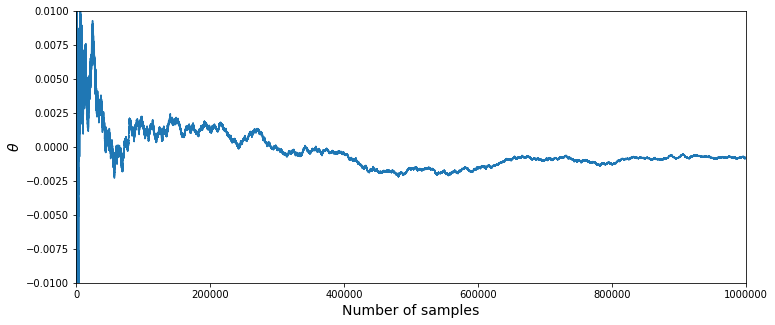

In [21]:
sample = np.random.randn(1000000)

sum_s = sample[0]
theta_n = sum_s / 1
history = [theta_n]
for N, s in enumerate(sample[1:], 2):
    sum_s += s
    theta_n = sum_s / N + 1 / N * (s - sum_s / N)
    history.append(theta_n)

plt.figure(figsize=(12, 5))
plt.plot(history)
plt.xlim(0, 1000000); plt.ylim(-0.01, 0.01)
plt.xlabel("Number of samples", fontsize=14); plt.ylabel("$\\theta$", fontsize=14)
plt.show()